In [1]:
from ocpa.algo.predictive_monitoring import factory as predictive_monitoring
from ocpa.algo.predictive_monitoring import tabular, sequential
import networkx as nx
import pandas as pd
from karateclub.graph_embedding import graph2vec
from karateclub import DeepWalk, Walklets
import node2vec 
from collections import Counter

C:\Users\linab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pm4py\objects\petri\__init__.py:19: UserWarning: please use the pm4py.objects.petri_net package instead.
  warnings.warn('please use the pm4py.objects.petri_net package instead.')
C:\Users\linab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pm4py\objects\petri\obj.py:19: UserWarning: pm4py.objects.petri.obj is deprecated. Please use the class pm4py.objects.petri_net.obj instead.
  warnings.warn("pm4py.objects.petri.obj is deprecated. Please use the class pm4py.objects.petri_net.obj instead.")
C:\Users\linab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pm4py\objects\petri\exporter\__init__.py:21: UserWarning: please use the pm4py.objects.petri_net.exporter package instead.
  warnings.warn('please use t

In [2]:
from ocpa.objects.log.importer.ocel import factory as ocel_import_factory

def load_ocel(path):
    if path.endswith("jsonocel"):
        ocel_file = ocel_import_factory.apply(path)
    elif path.endswith("xmlocel"):
        ocel_file = ocel_import_factory.apply(path)
    else:
        error_msg = "not a valid extension"
        return error_msg
    return ocel_file

In [3]:
from ocpa.objects.log.importer.csv import factory as ocel_import_factory_csv

def load_csv(path, params):
    ocel_file = ocel_import_factory_csv.apply(path, parameters=params)
    return ocel_file

In [4]:
def get_process_executions(ocel):
    # default: connected components
    return ocel.process_executions

def convert_process_executions_tolist(process_executions):
    process_executions_list = [list(process_ex) for process_ex in process_executions]
    return process_executions_list

def get_events_process_exection(ocel, id):
    return ocel.process_executions[id]

def get_objects_process_execution(ocel, id):
    return ocel.process_execution_objects[id]

def get_process_execution_graph(ocel, id):
    return ocel.get_process_execution_graph(id)

def get_variant_process_executions(ocel):
    return ocel.variants_dict()

In [5]:
def remap_nodes(graph):
    node_mapping = dict((node.event_id, i) for i, node in enumerate(graph.nodes))
    return node_mapping

def feature_graphs_to_nx_graphs(feature_graphs):
    graph_list = []
    for feature_graph in feature_graphs:
        #G = nx.DiGraph()
        G = nx.Graph()

        node_dict = remap_nodes(feature_graph)

        # replace node attribute dict keys (tuples) with only first part of tuple
        for node in feature_graph.nodes:
            new_keys = [key[0] for key in node.attributes.keys()]
            # graph2vec needs str features
            new_vals = [str(val) for val in node.attributes.values()]
            #node_attributes = dict(zip(new_keys, node.attributes.values()))
            node_attributes = dict(zip(new_keys, new_vals))
            G.add_node(node_dict[node.event_id], **node_attributes)
            #G.add_node(node.event_id, **node_attributes)

        for edge in feature_graph.edges:
            G.add_edge(node_dict[edge.source], node_dict[edge.target])
            #G.add_edge(edge.source, edge.target)

        graph_list.append(G)

    return graph_list

In [6]:
def extract_features(ocel_log, feature_set_event, feature_set_obj, repr):
    extraction = []
    feature_storage = predictive_monitoring.apply(ocel_log, feature_set_event, feature_set_obj)
    extraction.append(feature_storage)
    if repr == 'table':
        table = tabular.construct_table(feature_storage)
        extraction.append(table)
    elif repr == 'sequential':
        sequences = sequential.construct_sequence(feature_storage)
        extraction.append(sequences)
    return extraction

In [6]:
def construct_object_df(ocel_log):
    object_types = ocel_log.object_types
    df = pd.DataFrame(columns=[type for type in object_types])
    proc_ex = get_process_executions(ocel_log)
    num_pr_ex = len(proc_ex)
    for i in range(0, num_pr_ex):
        execution = proc_ex[i]
        obj = get_objects_process_execution(ocel_log, i)
        obj_count = Counter(elem[0] for elem in obj)
        obj_dict = pd.DataFrame([obj_count])
        df = pd.concat([df, obj_dict], ignore_index=True)
    return df

**Test Feature Extraction**

In [71]:
path = "C:\\Users\\linab\\Documents\\RWTH Aachen\\Studium\\Semester 3\\Process Discovery\\Samples\\BPI2017-Final.csv"
params = {"obj_names":["application", "offer"],
                "val_names":[],
                "act_name":"event_activity",
                "time_name":"event_timestamp",
                "sep":","}
ocel_log = load_csv(path, params)
#ocel_log = load_ocel(path)

In [72]:
from ocpa.algo.discovery.ocpn import algorithm as ocpn_discovery_factory
from ocpa.visualization.oc_petri_net import factory as ocpn_vis_factory

ocpn = ocpn_discovery_factory.apply(ocel_log, parameters={"debug": False})
ocpn_vis_factory.save(ocpn_vis_factory.apply(ocpn), "oc_petri_net12345.png")


C:\Users\linab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:1549: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


        event_CreditScore event_Action  event_FirstWithdrawalAmount  \
0                     NaN      Created                          NaN   
1                     NaN  statechange                          NaN   
2                     NaN     Obtained                          NaN   
3                     NaN  statechange                          NaN   
5                   979.0  statechange                      20000.0   
...                   ...          ...                          ...   
529890                NaN  statechange                          NaN   
529892                0.0  statechange                      20000.0   
529895                0.0     Obtained                      20000.0   
529897                0.0  statechange                      20000.0   
529899                0.0  statechange                      20000.0   

        event_NumberOfTerms event_Selected event_Accepted event_EventOrigin  \
0                       NaN            NaN            NaN       Appl

In [73]:
pe = get_process_executions(ocel_log)
print(convert_process_executions_tolist(pe))

[['349290', '349220', '349363', '349269', '349226', '349242', '349351', '349222', '349354', '349338', '349239', '349352', '349270', '349360', '349291', '349309', '349322', '349307', '349343', '349277', '349370', '349367', '349366', '349276', '349315', '349230', '349368', '349232', '349371', '349238', '349229', '349245', '349228', '349253', '349247', '349241', '349369', '349333', '349364', '349355', '349224'], ['459367', '459420', '459424', '459390', '459471', '459423', '459395', '459391', '459449', '459382', '459433', '459363', '459361', '459419', '459366', '459370', '459374', '459392', '459373', '459402', '459467', '459455', '459469', '459376', '459472', '459411', '459388', '459383', '459466', '459452', '459442', '459470', '459473', '459414', '459378', '459365', '459344', '459384', '459343', '459348', '459380'], ['852689', '852668', '852593', '852611', '852686', '852646', '852679', '852637', '852601', '852694', '852607', '852587', '852589', '852666', '852669', '852630', '852690', '852

In [74]:
pe_graph = ocel_log.graph.eog.subgraph(ocel_log.process_executions[1])

In [ ]:
for edge in pe_graph.edges():
    print(edge)
    print(edge[1])

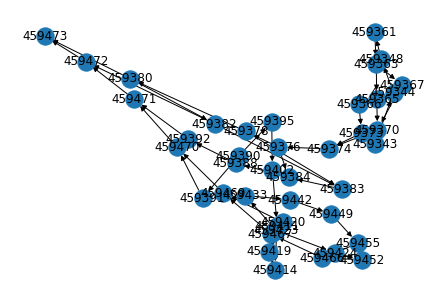

In [75]:
nx.draw(pe_graph, with_labels=True)

In [76]:
nx.info(pe_graph)

'DiGraph with 41 nodes and 51 edges'

In [16]:
# Feature extraction
activities = list(set(ocel_log.log.log["event_activity"].tolist()))
feature_set = [(predictive_monitoring.EVENT_REMAINING_TIME, ()),
               (predictive_monitoring.EVENT_ELAPSED_TIME, ()),
               (predictive_monitoring.EVENT_FLOW_TIME, ())]


In [77]:
feature_set_ex = [(predictive_monitoring.EXECUTION_NUM_OF_EVENTS, ()), 
                  (predictive_monitoring.EXECUTION_NUM_OF_END_EVENTS, ()),
                  (predictive_monitoring.EXECUTION_THROUGHPUT, ()), 
                  (predictive_monitoring.EXECUTION_NUM_OBJECT, ()),
                  (predictive_monitoring.EXECUTION_NUM_OF_EVENTS, ()), 
                  (predictive_monitoring.EXECUTION_UNIQUE_ACTIVITIES, ()),
                  (predictive_monitoring.EXECUTION_NUM_OF_STARTING_EVENTS, ()), 
                  (predictive_monitoring.EXECUTION_LAST_EVENT_TIME_BEFORE, ())]

In [78]:
#feature_storage = extract_features(ocel_log, feature_set, [], "")[0]
feature_storage = extract_features(ocel_log, feature_set, feature_set_ex, "")[0]

In [79]:
# get first graph
feature_graph = feature_storage.feature_graphs[0]

In [19]:
for key in feature_graph.nodes[0].attributes.keys():
    print(key[0])

event_remaining_time
event_elapsed_time
event_flow_time


In [ ]:
# print graph attributes
feature_graph.attributes

In [ ]:
# print nodes
for node in feature_graph.nodes:
    print(node.event_id)
    print(node.attributes)
    print(node.objects)

In [ ]:
# print edges source/ target
for edge in feature_graph.edges:
    print(edge.source, edge.target)
    print(edge.attributes)
    print(edge.objects)

In [80]:
# get nx graph
feature_nx_graph = feature_graphs_to_nx_graphs([feature_graph])[0]

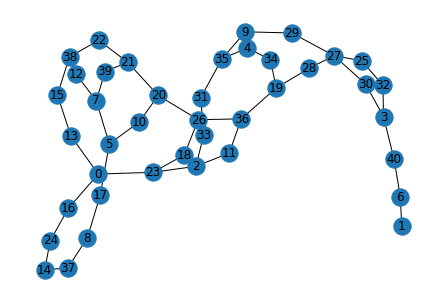

In [81]:
# draw graph
nx.draw(feature_nx_graph, with_labels=True)

In [82]:
from karateclub.graph_embedding import graph2vec

def perform_graph2vec(graph_list, attributed):
    model = graph2vec.Graph2Vec(attributed=attributed)
    model.fit(graph_list)
    X = model.get_embedding()

    return X

In [83]:
X = perform_graph2vec([feature_nx_graph], False)

In [84]:
X

array([[ 6.3945549e-03,  7.4957763e-03,  6.3900012e-03, -6.1347182e-03,
        -6.7919777e-03, -3.6242928e-03, -3.4278668e-03,  3.6854271e-03,
        -5.3344760e-03, -6.7679775e-03, -3.7007183e-03,  7.7731684e-03,
        -3.7292328e-03,  1.2001731e-03,  7.0385872e-03,  3.4680474e-03,
        -7.7775127e-04,  7.4692359e-03, -4.7607296e-03,  4.4248607e-03,
         3.2281461e-03, -2.8169858e-03, -7.4698060e-04, -7.0495363e-03,
         4.2197946e-05, -2.1244744e-03,  7.9350993e-03, -3.7782518e-03,
        -5.4091839e-03,  8.9913607e-04, -6.2586423e-03, -6.3770837e-03,
        -5.2485019e-03, -4.8806965e-03, -3.4809883e-03, -1.5719670e-03,
        -1.9878231e-03,  4.6168352e-03,  5.4710223e-03, -3.6306109e-03,
        -5.0782845e-03,  6.2459928e-04, -3.6098342e-03,  2.0682870e-05,
         5.7452545e-03,  3.1097236e-03, -4.3315450e-03, -1.0271193e-03,
         1.4646169e-04, -6.4706560e-03,  7.8950441e-03,  6.6572037e-03,
        -2.3878061e-05,  4.6833633e-03,  3.6077541e-03,  6.93371

**Extension for all process executions**

In [87]:
feature_graph_list = feature_storage.feature_graphs
feature_nx_graph_list = feature_graphs_to_nx_graphs(feature_graph_list)

In [88]:
print(feature_nx_graph_list[0])

Graph with 41 nodes and 49 edges


In [89]:
print(feature_nx_graph_list[0].nodes)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [90]:
embedding =perform_graph2vec(feature_nx_graph_list, False)

In [91]:
embedding

array([[ 0.1190043 , -0.0391168 , -0.08758996, ...,  0.01425083,
        -0.00798875,  0.02308978],
       [ 0.13099304, -0.0442359 , -0.10922147, ...,  0.00759249,
        -0.00623998,  0.01625188],
       [ 0.12360165, -0.05069126, -0.10493165, ...,  0.00236955,
        -0.01628441,  0.02408379],
       ...,
       [ 0.05693608, -0.03128374, -0.04691653, ...,  0.01309955,
        -0.00601182, -0.00110666],
       [ 0.06780784, -0.03028451, -0.04737418, ...,  0.01461518,
        -0.00963726,  0.00376862],
       [ 0.08476681, -0.04456697, -0.07589132, ...,  0.00698136,
        -0.01274955,  0.01259329]], dtype=float32)

In [26]:
# try normalize embedding
from sklearn import preprocessing
embedding_normalized = preprocessing.normalize(embedding)
print(embedding_normalized)

[[0.12319247 0.14356577 0.12179358 ... 0.0970394  0.05830279 0.09929608]
 [0.1263644  0.15577503 0.11646895 ... 0.09067282 0.06454054 0.09714668]
 [0.13791795 0.1409962  0.10369705 ... 0.08517721 0.03977696 0.1161221 ]
 ...
 [0.13692299 0.14764671 0.15588343 ... 0.07899855 0.01123955 0.08857007]
 [0.09543333 0.10361338 0.13392626 ... 0.1189734  0.06986946 0.11008981]
 [0.1246822  0.12609412 0.12051628 ... 0.10925705 0.07603291 0.10410952]]


**Clustering**

In [92]:
from sklearn.cluster import DBSCAN 

def perform_DBSCAN(X, eps, min_samples):
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)

    return labels

In [93]:
labels = perform_DBSCAN(embedding, 0.1, 10)
print(labels)

[0 0 0 ... 0 0 0]


In [94]:
labels_norm = perform_DBSCAN(embedding_normalized, 0.3, 5)
print(labels_norm)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0 -1 -1  0]


In [37]:
from sklearn.cluster import MeanShift

def perform_MeanShift(X):
    clustering = MeanShift().fit(X)

    return clustering.labels_

In [38]:
perform_MeanShift(embedding)

array([2, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [39]:
perform_MeanShift(embedding_normalized)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 3, 6, 0,
       0, 2, 5, 0], dtype=int64)

**Try adding a feature**

In [40]:
def feature_graphs_to_nx_graphs_single_feature(feature_graphs):
    graph_list = []
    for feature_graph in feature_graphs:
        #G = nx.DiGraph()
        G = nx.Graph()

        node_dict = remap_nodes(feature_graph)

        # replace node attribute dict keys (tuples) with only first part of tuple
        for node in feature_graph.nodes:
            # graph2vec needs str features
            new_val = [str(val) for val in node.attributes.values()][0]
            G.add_node(node_dict[node.event_id], feature=new_val)
            #G.add_node(node.event_id, **node_attributes)

        for edge in feature_graph.edges:
            G.add_edge(node_dict[edge.source], node_dict[edge.target])
            #G.add_edge(edge.source, edge.target)

        graph_list.append(G)

    return graph_list

In [41]:
# Feature extraction
feature_set_single = [(predictive_monitoring.EVENT_REMAINING_TIME, ())]
feature_storage_single = extract_features(ocel_log, feature_set_single, [], "")[0]

In [42]:
feature_graph_list_single = feature_storage_single.feature_graphs
feature_nx_graph_list_single = feature_graphs_to_nx_graphs_single_feature(feature_graph_list_single)

In [ ]:
nx.get_node_attributes(feature_nx_graph_list_single[0], 'feature')

In [44]:
embedding_single = perform_graph2vec(feature_nx_graph_list_single, True)

In [53]:
labels_single = perform_DBSCAN(embedding_single, 0.1, 5)
print(labels_single)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


In [49]:
perform_MeanShift(embedding_single)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

**Cluster Executions based on execution features**

In [95]:
feature_set_ex = [
                  (predictive_monitoring.EXECUTION_NUM_OF_EVENTS, ()), 
                  (predictive_monitoring.EXECUTION_NUM_OF_END_EVENTS, ()),
                  (predictive_monitoring.EXECUTION_THROUGHPUT, ()), 
                  (predictive_monitoring.EXECUTION_NUM_OBJECT, ()),
                  (predictive_monitoring.EXECUTION_UNIQUE_ACTIVITIES, ()),
                  (predictive_monitoring.EXECUTION_NUM_OF_STARTING_EVENTS, ()), 
                  (predictive_monitoring.EXECUTION_LAST_EVENT_TIME_BEFORE, ())
                  ]

In [96]:
feature_storage = extract_features(ocel_log, [], feature_set_ex, "")[0]

In [97]:
ex_features_list = []
for i, graph in enumerate(feature_storage.feature_graphs):
    features = (list(graph.attributes.values()))
    features.insert(0, i)
    ex_features_list.append(features)

In [98]:
exec_feature_df = pd.DataFrame(ex_features_list, columns=['id', "EXECUTION_NUM_OF_EVENTS", "EXECUTION_NUM_OF_END_EVENTS", "EXECUTION_THROUGHPUT", "EXECUTION_NUM_OBJECT", "EXECUTION_UNIQUE_ACTIVITIES", "EXECUTION_NUM_OF_STARTING_EVENTS", "EXECUTION_LAST_EVENT_TIME_BEFORE"])

In [99]:
execution_cluster_df = exec_feature_df.loc[:, exec_feature_df.columns != 'id']

In [101]:
exec_feature_df.head(5)

,id,EXECUTION_NUM_OF_EVENTS,EXECUTION_NUM_OF_END_EVENTS,EXECUTION_THROUGHPUT,EXECUTION_NUM_OBJECT,EXECUTION_UNIQUE_ACTIVITIES,EXECUTION_NUM_OF_STARTING_EVENTS,EXECUTION_LAST_EVENT_TIME_BEFORE
0,0,41,1,1.158364e+07,10,13,1,0.012
1,1,41,1,4.567209e+06,11,14,1,0.015
2,2,41,1,3.123307e+06,10,13,1,0.007
3,3,38,1,1.155379e+07,8,13,1,0.013
4,4,38,1,5.840871e+05,9,13,1,0.009


In [60]:
# normalization
normalized_df=(execution_cluster_df-execution_cluster_df.mean())/execution_cluster_df.std()

In [ ]:
normalized_df.head()

In [103]:
execution_labels = perform_DBSCAN(execution_cluster_df, 0.5, 2)
print(execution_labels)

[-1 -1 -1 ... -1 -1 -1]


In [104]:
execution_labels_meanshift = perform_MeanShift(execution_cluster_df)
print(execution_labels_meanshift)

[8 1 1 ... 0 0 0]


**Partition OCEL based on Clusters**

In [105]:
from ocpa.objects.log.util import misc as log_util

def partition_ocel(ocel, clustered_df):
    sub_ocels = [] 

    for cluster in clustered_df['cluster'].unique():
        # partition df into df of cluster 
        cluster_df = clustered_df[clustered_df['cluster'] == cluster]
        # get id of process execution
        cluster_process_ex = list(cluster_df.index.values)
        # get corresponding event ids -> use process_execution_mappings function, that stores process execution ids of an event
        event_ids = [key for (key,val) in ocel.process_execution_mappings.items() if val in cluster_process_ex]
        # copy part of log containing only event ids of cluster
        new_event_df = ocel.log.log.loc[ocel.log.log["event_id"].isin(event_ids)].copy()
        # synthetically add ocel parameters (muss noch angepasst werden, ist ja gerade hardgecoded auf die column names)
        ocel.parameters = {"obj_names": ocel.object_types, "val_names":[], "act_name": "event_activity", "time_name":"event_timestamp"}
        # copy log 
        new_log = log_util.copy_log_from_df(new_event_df, ocel.parameters)
        sub_ocels.append(new_log)
    
    return sub_ocels

In [106]:
# add cluster label
exec_feature_df['cluster'] = execution_labels_meanshift

In [107]:
sub_ocels = partition_ocel(ocel_log, exec_feature_df)

KeyboardInterrupt: 

In [ ]:
from ocpa.algo.discovery.ocpn import algorithm as ocpn_discovery_factory
from ocpa.visualization.oc_petri_net import factory as ocpn_vis_factory

In [ ]:
for i, sub_ocel in enumerate(sub_ocels):
    ocpn = ocpn_discovery_factory.apply(sub_ocel, parameters={"debug": False})
    img_name = "BPIFINAL_test_cluster_meanshift_order_" + str(i)
    ocpn_vis_factory.save(ocpn_vis_factory.apply(ocpn), "clustering_test/" + img_name +".png")

C:\Users\linab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:1549: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


     event_id             time:timestamp      concept:name  \
0           5 2022-10-20 17:06:18.864004       Place Order   
3           6 2022-10-20 17:06:19.864004     Confirm Order   
8           9 2022-10-20 17:11:47.864004         Pay Order   
10         26 2022-10-20 17:35:00.864004       Place Order   
13         27 2022-10-20 17:35:01.864004     Confirm Order   
...       ...                        ...               ...   
2724     1890 2022-10-31 08:46:18.870968  Payment Reminder   
2728     1893 2022-10-31 14:24:31.870968         Pay Order   
2729     1896 2022-10-31 21:08:02.870968  Payment Reminder   
2744     1904 2022-11-02 10:39:59.870968         Pay Order   
2745     1906 2022-11-02 23:09:16.870968         Pay Order   

          event_start_timestamp case:concept:name  
0    2022-10-20 17:06:18.864004            order2  
3    2022-10-20 17:06:19.864004            order2  
8    2022-10-20 17:11:47.864004            order2  
10   2022-10-20 17:35:00.864004            orde

C:\Users\linab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\frame.py:1549: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(


    event_id             time:timestamp      concept:name  \
0          0 2022-10-20 16:56:19.864004       Place Order   
3          1 2022-10-20 16:56:20.864004     Confirm Order   
8          4 2022-10-20 17:01:51.864004         Pay Order   
9         11 2022-10-20 17:16:12.864004       Place Order   
12        12 2022-10-20 17:16:13.864004     Confirm Order   
..       ...                        ...               ...   
468     1828 2022-10-29 05:30:52.869990         Pay Order   
469     1832 2022-10-29 10:23:46.870968  Payment Reminder   
498     1891 2022-10-31 12:45:03.870968  Payment Reminder   
506     1905 2022-11-02 14:51:06.870968  Payment Reminder   
535     1939 2022-11-04 16:44:33.870968         Pay Order   

         event_start_timestamp case:concept:name  
0   2022-10-20 16:56:19.864004            order1  
3   2022-10-20 16:56:20.864004            order1  
8   2022-10-20 17:01:51.864004            order1  
9   2022-10-20 17:16:12.864004            order3  
12  2022-10-